In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
from collections import Counter
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.style as mplstyle
import matplotlib.patches as mpatches
from matplotlib.ticker import (PercentFormatter,MultipleLocator, AutoMinorLocator)
import seaborn as sns

In [2]:
conn = psycopg2.connect(database="postgres",
                        host="pklmartdb.ckkvdwandqoa.us-east-1.rds.amazonaws.com",
                        user="cmcnicholas",
                        password="momentum101",
                        port="5432")
conn.autocommit = True

In [3]:
def pullawsdata(tablename):
    with conn,conn.cursor() as cursor:
        try:
            cursor.execute(f"SELECT column_name FROM information_schema.columns where table_name='{tablename}';")
            cols=cursor.fetchall()
            cols = [cols[x][0] for x in range(len(cols))]
            cursor.execute(f"SELECT * FROM pklm_prd.{tablename}")
            data=cursor.fetchall()
            return(pd.DataFrame(data,columns=cols))
        except Exception as inst:
            print(type(inst))    
            print(inst.args)     
            print(inst)

In [4]:
rally=pullawsdata('rally')

In [5]:
rally = rally[['game_id', 'rally_id', 'rally_nbr', 'srv_team_id', 'w_team_id', 'to_team_id']]
rally['game_id'] = [int(x[1:]) for x in rally.game_id]
rally['rally_id'] = [int(x[1:]) for x in rally.rally_id]
rally = rally.sort_values(['game_id', 'rally_id', 'rally_nbr']).reset_index(drop=True)

In [6]:
game=pullawsdata('game')[['match_id','game_id','game_nbr','score_w','score_l','w_team_id','l_team_id','skill_lvl']]
game['game_id'] = [int(x[1:]) for x in game.game_id]
game['match_id'] = [int(x[1:]) for x in game.match_id]
game.skill_lvl.iloc[game.skill_lvl == '4'] = '4.0'
game.skill_lvl.iloc[game.skill_lvl == '5'] = '5.0'
game = game.sort_values(['match_id','game_id']).reset_index(drop=True)

In [7]:
rally.head()

,game_id,rally_id,rally_nbr,srv_team_id,w_team_id,to_team_id
0,1,1,1,T1,T2,N/A
1,1,2,2,T2,T2,N/A
2,1,3,3,T2,T2,N/A
3,1,4,4,T2,T2,N/A
4,1,5,5,T2,T1,N/A


In [8]:
glist = list(rally.game_id.unique())
dlist = []

for i in range(len(glist)):
    gi = rally[rally.game_id==glist[i]].reset_index(drop=True)
    to_list = []
    to_game = glist[i]
    to_inds = list(gi.index[gi.to_team_id != 'N/A'])
    to_teams = list(gi.to_team_id[gi.to_team_id != 'N/A'])
    skill_lvl = list(game.skill_lvl[game.game_id == glist[i]])[0]
    if (len(to_inds) > 0):
        for j in range(len(to_inds)):
            if j == 0:
                pre = list(range(to_inds[j]))
            else:
                pre = list(range(to_inds[j-1]+1,to_inds[j]))
            if j == len(to_inds)-1:
                post = list(range(to_inds[j]+1,len(gi)))
            else:
                post = list(range(to_inds[j]+1,to_inds[j+1]))
            toteam = to_teams[j]
            rallynbr = gi.rally_nbr.iloc[to_inds[j]]
            
            winpre = round(100*len(gi.iloc[pre][lambda x:x.w_team_id == toteam])/len(pre),1)
            winpost = round(100*len(gi.iloc[post][lambda x:x.w_team_id == toteam])/len(post),1)
            windelta = round(winpost-winpre,1)
            
            srvpre = gi.iloc[pre][lambda x:x.srv_team_id == toteam]
            rcvpre = gi.iloc[pre][lambda x:x.srv_team_id != toteam]

            srvlenpre=len(srvpre)
            rcvlenpre=len(rcvpre)
            
            srvpost = gi.iloc[post][lambda x:x.srv_team_id == toteam]
            rcvpost = gi.iloc[post][lambda x:x.srv_team_id != toteam]

            srvlenpost=len(srvpost)
            rcvlenpost=len(rcvpost)
            
            if srvlenpre > 0:
                srvwinpre = round(100*len(srvpre.loc[lambda x:x.w_team_id == toteam])/srvlenpre,1)
            else:
                srvwinpre = None
            if srvlenpost > 0:
                srvwinpost = round(100*len(srvpost.loc[lambda x:x.w_team_id == toteam])/srvlenpost,1)
            else:
                srvwinpost = None
            if srvlenpre > 0 and srvlenpost > 0:
                srvwindelta = round(srvwinpost-srvwinpre,1)
            else:
                srvwindelta = None
                
            
            if rcvlenpre > 0:
                rcvwinpre = round(100*len(rcvpre.loc[lambda x:x.w_team_id == toteam])/rcvlenpre,1)
            else:
                rcvwinpre = None
            if rcvlenpost > 0:
                rcvwinpost = round(100*len(rcvpost.loc[lambda x:x.w_team_id == toteam])/rcvlenpost,1)
            else:
                rcvwinpost = None
            if rcvlenpre > 0 and rcvlenpost > 0:
                rcvwindelta = round(rcvwinpost-rcvwinpre,1)
            else:
                rcvwindelta = None
        
            
            dlist.append([to_game,skill_lvl,j+1,toteam,rallynbr,winpre,winpost,windelta,srvwinpre,srvwinpost,srvwindelta,rcvwinpre,rcvwinpost,rcvwindelta])

In [9]:
df_timeout = pd.DataFrame(dlist,columns=['game_id','skill_lvl','to_nbr','to_team','rally_nbr','prewin','postwin','deltawin','prewinsrv','postwinsrv','deltawinsrv','prewinrcv','postwinrcv','deltawinrcv'])

In [10]:
print('change in win percentage due to timeouts\n')
print(f'average: {round(df_timeout.deltawin.mean(),1)}')
print(f'median:  {df_timeout.deltawin.median()}')
print(f'maximum: {df_timeout.deltawin.max()}')
print(f'minimum: {df_timeout.deltawin.min()}')                                                      

change in win percentage due to timeouts

average: 5.9
median:  7.3
maximum: 60.0
minimum: -63.6


In [11]:
print('change in win percentage AS SERVER due to timeouts\n')
print(f'average: {round(df_timeout.deltawinsrv.mean(),1)}')
print(f'median:  {df_timeout.deltawinsrv.median()}')
print(f'maximum: {df_timeout.deltawinsrv.max()}')
print(f'minimum: {df_timeout.deltawinsrv.min()}') 

change in win percentage AS SERVER due to timeouts

average: 9.8
median:  9.0
maximum: 100.0
minimum: -66.7


In [12]:
print('change in win percentage AS RECEIVER due to timeouts\n')
print(f'average: {round(df_timeout.deltawinrcv.mean(),1)}')
print(f'median:  {df_timeout.deltawinrcv.median()}')
print(f'maximum: {df_timeout.deltawinrcv.max()}')
print(f'minimum: {df_timeout.deltawinrcv.min()}') 

change in win percentage AS RECEIVER due to timeouts

average: 3.6
median:  0.0
maximum: 80.0
minimum: -57.1


In [13]:
print('all:')
print(df_timeout.prewin.count())
print(df_timeout.postwin.count())
print(df_timeout.deltawin.count())
print('\nserving:')
print(df_timeout.prewinsrv.count())
print(df_timeout.postwinsrv.count())
print(df_timeout.deltawinsrv.count())
print('\n')
print('\nreceiving')
print(df_timeout.prewinrcv.count())
print(df_timeout.postwinrcv.count())
print(df_timeout.deltawinrcv.count())
df_timeout.columns

all:
81
81
81

serving:
79
71
69



receiving
80
73
73


Index(['game_id', 'skill_lvl', 'to_nbr', 'to_team', 'rally_nbr', 'prewin',
       'postwin', 'deltawin', 'prewinsrv', 'postwinsrv', 'deltawinsrv',
       'prewinrcv', 'postwinrcv', 'deltawinrcv'],
      dtype='object')

In [14]:
df_timeout.head(20)

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv
0,1,Pro,1,T1,22,38.1,64.3,26.2,12.5,50.0,37.5,53.8,83.3,29.5
1,1,Pro,2,T2,37,35.7,33.3,-2.4,16.7,0.0,-16.7,50.0,50.0,0.0
2,1,Pro,3,T2,50,33.3,70.0,36.7,0.0,60.0,60.0,50.0,80.0,30.0
3,1,Pro,4,T1,61,30.0,0.0,-30.0,20.0,NaN,NaN,40.0,0.0,-40.0
4,2,Pro,1,T2,8,28.6,48.4,19.8,50.0,28.6,-21.4,20.0,64.7,44.7
5,2,Pro,2,T1,40,51.6,66.7,15.1,35.3,0.0,-35.3,71.4,100.0,28.6
6,2,Pro,3,T2,44,33.3,50.0,16.7,0.0,33.3,33.3,100.0,75.0,-25.0
7,3,Pro,1,T2,32,54.8,50.0,-4.8,52.9,66.7,13.8,57.1,33.3,-23.8
8,4,Pro,1,T2,22,42.9,61.1,18.2,22.2,36.4,14.2,58.3,100.0,41.7
9,4,Pro,2,T3,41,38.9,57.1,18.2,0.0,42.9,42.9,63.6,71.4,7.8


In [15]:
len(rally[rally.to_team_id != 'N/A'].to_team_id)

81

In [16]:
df_timeout.sort_values('deltawin').to_csv('timeout_momentum_srv_rcv_sorted.csv',index=False)

In [17]:
df_wteam = game[['w_team_id','game_id']].groupby('w_team_id').count().reset_index(drop=False)
df_lteam = game[['l_team_id','game_id']].groupby('l_team_id').count().reset_index(drop=False)
df_wteam.columns=['team_id','won']
df_lteam.columns=['team_id','lost']
df_wl=df_wteam.merge(df_lteam,on='team_id',how='left')
df_lw=df_lteam.merge(df_wteam,on='team_id',how='left')
df_wnl = df_wl[df_wl.lost.notnull()]
df_w=df_wl[df_wl.lost.isnull()]
df_l=df_lw[df_lw.won.isnull()]
df_allres = pd.concat([pd.concat([df_wnl,df_w]),df_l]).fillna(0)
df_allres['GP'] = df_allres['won']+df_allres['lost']
df_allres[['won','lost','GP']] = df_allres[['won','lost','GP']].astype(int)
df_allres['team_id'] = [int(x[1:]) for x in df_allres.team_id]
df_allres = df_allres.sort_values('team_id')
df_allres.team_id = 'T'+df_allres.team_id.astype(str)
df_tobyteam = df_timeout[['to_team','game_id']].groupby('to_team').count().reset_index(drop=False)
df_tobyteam.columns = ['team_id','TO']
df_teammetrx = df_allres.merge(df_tobyteam,on='team_id',how='left')
df_teammetrx.TO = df_teammetrx['TO'].fillna(0).astype(int)
df_teammetrx['TOsPerGame'] = (df_teammetrx.TO/df_teammetrx.GP).round(2)
df_teamcalc = df_timeout[['to_team','deltawin']].groupby('to_team').mean().round(1).reset_index(drop=False)
df_teamcalc.columns=['team_id','avgDeltaWin']
df_teammetrx = df_teammetrx.merge(df_teamcalc,on='team_id',how='left')
df_teammetrx=df_teammetrx[['team_id', 'GP', 'TO', 'TOsPerGame', 'avgDeltaWin']]
df_teammetrx = df_teammetrx.sort_values('avgDeltaWin',ascending=False).merge(pullawsdata('team')[['team_id','team_nm']],on='team_id',how='left').drop_duplicates()
df_teammetrx.to_csv('team_timeout_data.csv',index=False)
print('team timeout data, sorted descending by average win % change:\n ')
df_teammetrx.head()

team timeout data, sorted descending by average win % change:
 


,team_id,GP,TO,TOsPerGame,avgDeltaWin,team_nm
0,T9,2,1,0.50,60.0,Jesse Irvine & Anna Bright
2,T17,2,1,0.50,50.0,Ben Johns & Tyler Loong
4,T11,1,1,1.00,49.2,Chrissy Penfold & Eli Powell
6,T48,3,1,0.33,49.0,Monica Linn & Christian Keenum
8,T18,2,2,1.00,38.6,Collin Johns & AJ Koller


In [18]:
df_skill = game[['skill_lvl','game_id']].groupby('skill_lvl').count().round(1).reset_index(drop=False)
df_skill.columns=[['skill_lvl','games']]
df_skill['delta_win_srv'] = (df_timeout[['skill_lvl','deltawinsrv']].groupby('skill_lvl').mean().round(1).reset_index(drop=False))['deltawinsrv']
df_skill['delta_win_rcv'] = (df_timeout[['skill_lvl','deltawinrcv']].groupby('skill_lvl').mean().round(1).reset_index(drop=False))['deltawinrcv']
df_skill['delta_win'] = (df_timeout[['skill_lvl','deltawin']].groupby('skill_lvl').mean().round(1).reset_index(drop=False))['deltawin']
df_skill[['skill_lvl','games','delta_win_srv','delta_win_rcv','delta_win']].reset_index(drop=True)

,skill_lvl,games,delta_win_srv,delta_win_rcv,delta_win
0,4.0,3,-0.6,0.4,-6.2
1,4.5,7,-14.2,-1.6,-0.8
2,5.0,26,21.4,-2.8,9.8
3,Pro,40,7.9,5.7,5.9


In [19]:
df_avgdelta = df_timeout[['deltawin','deltawinsrv','deltawinrcv']].mean().round(1).reset_index(drop=False)
df_avgdelta.columns=[['metric','avg_change']]
df_avgdelta

,metric,avg_change
0,deltawin,5.9
1,deltawinsrv,9.8
2,deltawinrcv,3.6


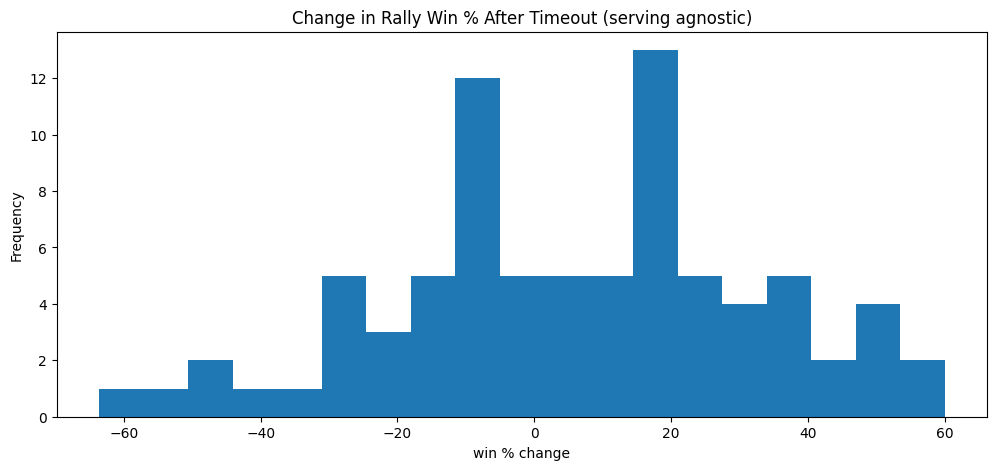

In [20]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawin, bins=19)
plt.gca().set(title='Change in Rally Win % After Timeout (serving agnostic)', xlabel = 'win % change', ylabel='Frequency');

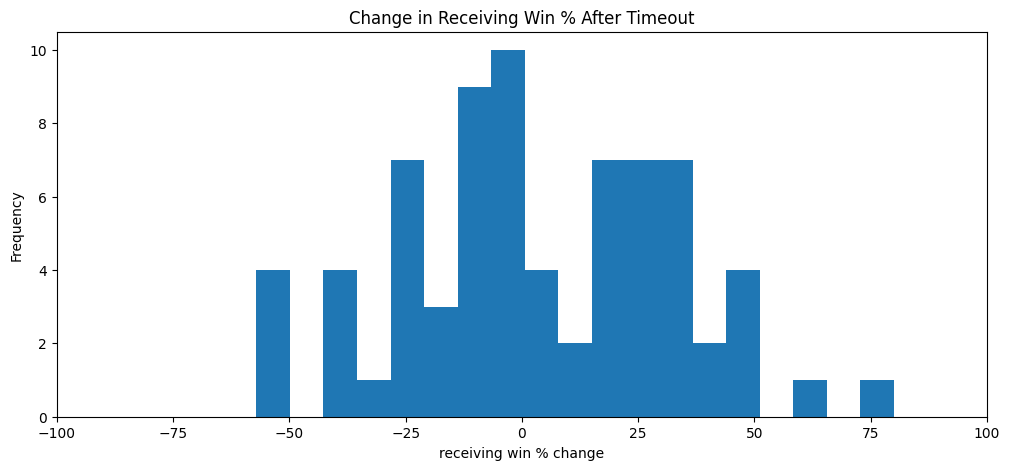

In [21]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinrcv, bins=19)
plt.gca().set(title='Change in Receiving Win % After Timeout', xlim=[-100,100],xlabel = 'receiving win % change', ylabel='Frequency');

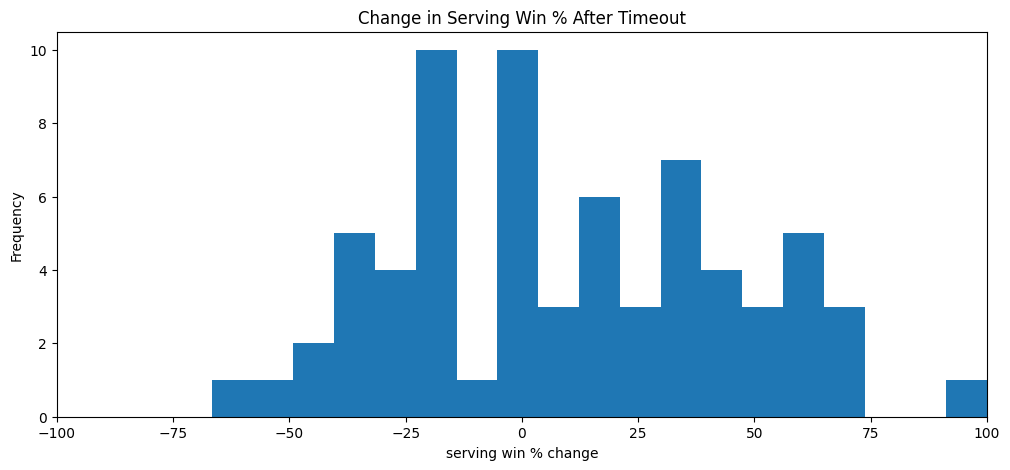

In [22]:
%matplotlib inline
plt.rcParams.update({'figure.figsize':(12,5), 'figure.dpi':100})
plt.hist(df_timeout.deltawinsrv, bins=19)
plt.gca().set(title='Change in Serving Win % After Timeout', xlim=[-100,100],xlabel = 'serving win % change', ylabel='Frequency');

## Group plots by skill level

In [23]:
df_pro=df_timeout[df_timeout.skill_lvl == 'Pro']
df_40=df_timeout[df_timeout.skill_lvl == '4.0']
df_45=df_timeout[df_timeout.skill_lvl == '4.5']
df_50=df_timeout[df_timeout.skill_lvl == '5.0']
skilldata=[list(x.deltawin) for x in [df_40,df_45,df_50,df_pro,df_timeout]]
skilldatasrv=[list(x.deltawinsrv) for x in [df_40,df_45,df_50,df_pro,df_timeout]]
skilldatarcv=[list(x.deltawinrcv) for x in [df_40,df_45,df_50,df_pro,df_timeout]]

In [24]:
import numpy as np
np.linspace(1,5,5)

array([1., 2., 3., 4., 5.])

In [25]:
rally[rally.game_id == 55]

,game_id,rally_id,rally_nbr,srv_team_id,w_team_id,to_team_id
2369,55,2560,1,T44,T44,N/A
2370,55,2561,2,T44,T44,N/A
2371,55,2562,3,T44,T45,N/A
2372,55,2563,4,T45,T45,N/A
2373,55,2564,5,T45,T45,N/A
2374,55,2565,6,T45,T44,N/A
2375,55,2566,7,T45,T45,N/A
2376,55,2567,8,T45,T44,N/A
2377,55,2568,9,T44,T45,N/A
2378,55,2569,10,T44,T45,N/A


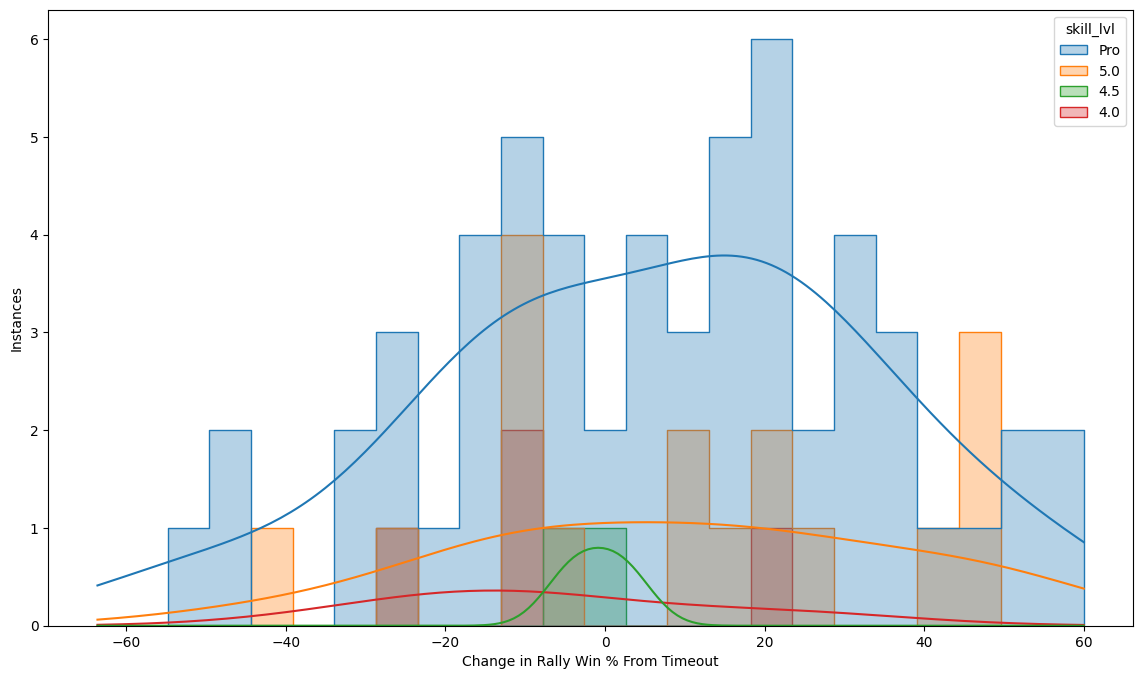

In [26]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p = sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

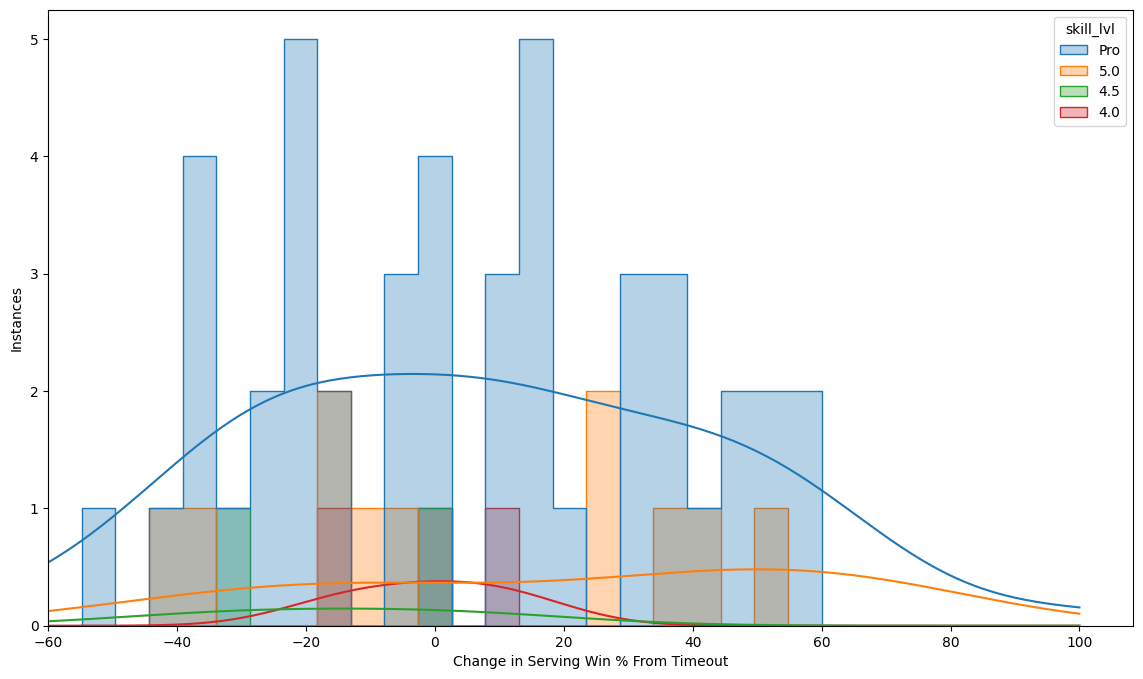

In [27]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p = sns.histplot(x="deltawinsrv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Serving Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
p.set_xlim(-60)
plt.show()

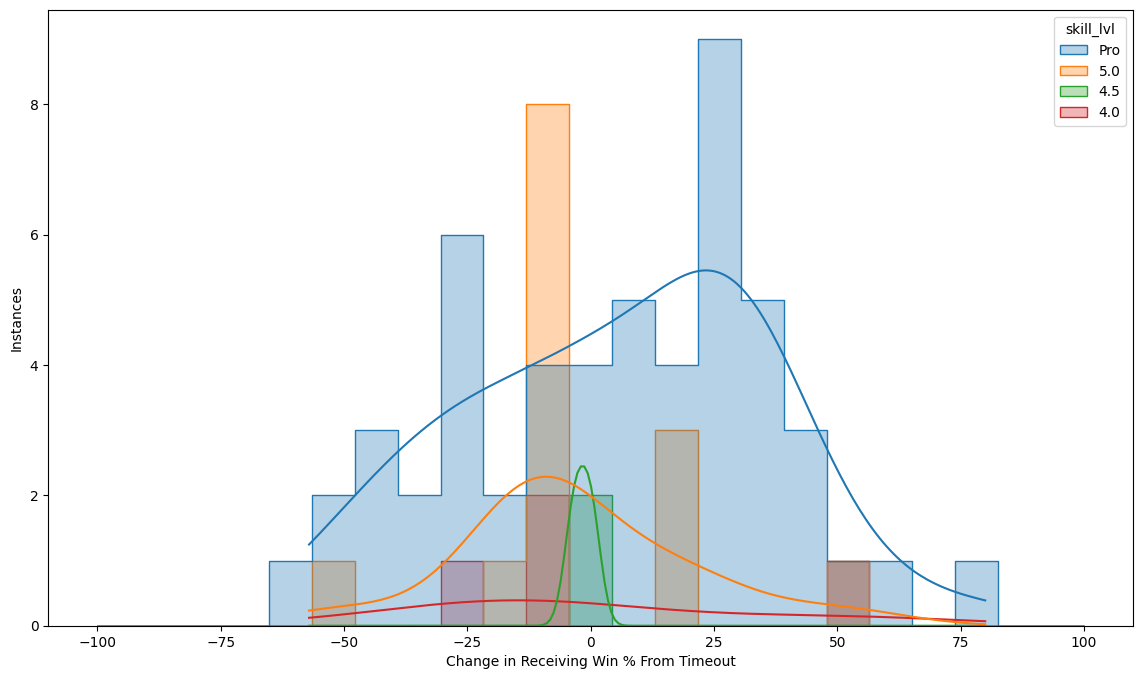

In [28]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 24)
p = sns.histplot(x="deltawinrcv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Receiving Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

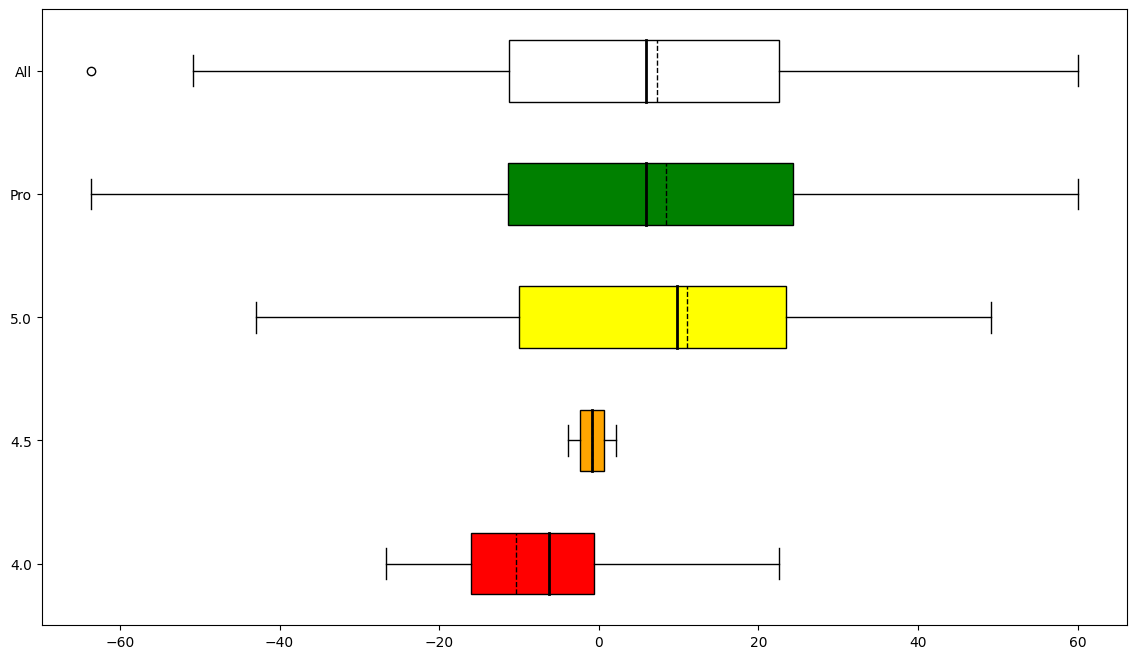

In [29]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['4.0','4.5','5.0','Pro','All'])

colors = ['red', 'orange', 'yellow', 'green', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
plt.show()

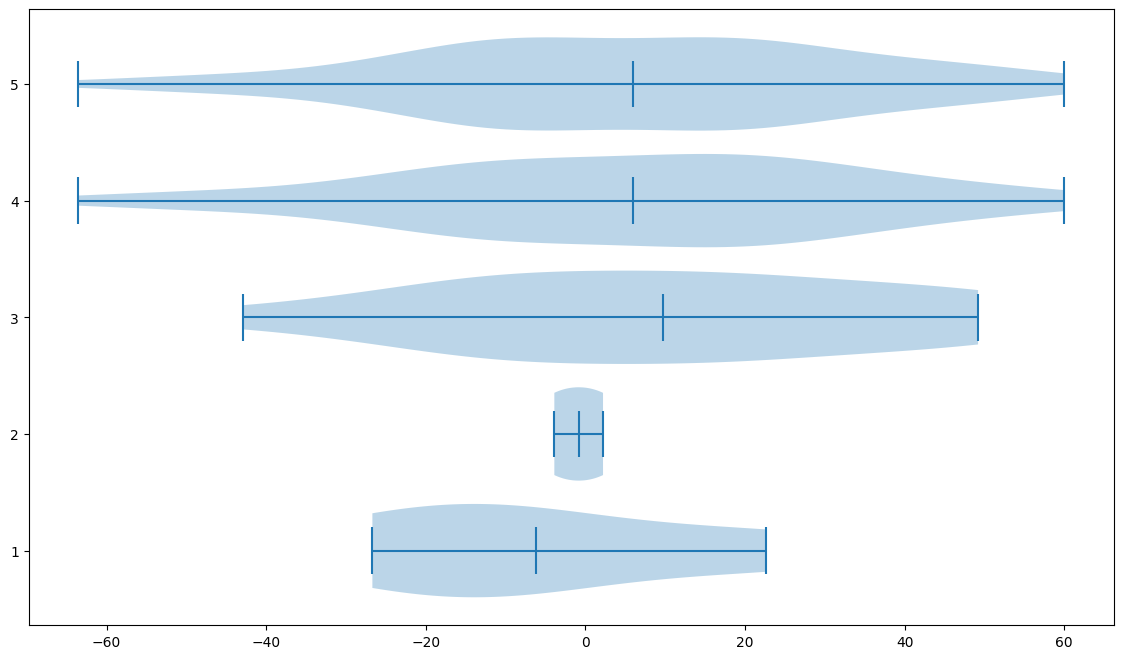

In [30]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()

## Repeat plots - but distinguishing between only 2 skill levels:  "Pro" and "Amateur"

In [31]:
df_timeout_bypro = df_timeout
df_timeout_bypro.skill_lvl.iloc[df_timeout_bypro.skill_lvl != 'Pro'] = 'Amateur'
df_pro=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Pro']
df_amtr=df_timeout_bypro[df_timeout_bypro.skill_lvl == 'Amateur']
skilldata=[list(x.deltawin) for x in [df_amtr,df_pro,df_timeout_bypro]]

In [32]:
df_timeout_bypro.sort_values('deltawin').head(10)

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv
43,28,Pro,2,T25,49,63.6,0.0,-63.6,71.4,NaN,NaN,50.0,0.0,-50.0
39,23,Pro,2,T21,68,50.9,0.0,-50.9,42.9,0.0,-42.9,59.3,NaN,NaN
45,30,Pro,1,T25,20,47.4,0.0,-47.4,55.6,NaN,NaN,40.0,0.0,-40.0
21,12,Pro,1,T6,40,46.2,0.0,-46.2,33.3,NaN,NaN,57.1,0.0,-57.1
53,38,Amateur,2,T38,45,42.9,0.0,-42.9,33.3,NaN,NaN,50.0,0.0,-50.0
72,58,Pro,2,T46,40,33.3,0.0,-33.3,0.0,NaN,NaN,50.0,0.0,-50.0
3,1,Pro,4,T1,61,30.0,0.0,-30.0,20.0,NaN,NaN,40.0,0.0,-40.0
77,74,Amateur,1,T58,16,26.7,0.0,-26.7,25.0,NaN,NaN,27.3,0.0,-27.3
11,5,Pro,1,T3,27,46.2,20.0,-26.2,25.0,0.0,-25.0,64.3,25.0,-39.3
27,16,Pro,1,T4,39,50.0,25.0,-25.0,50.0,NaN,NaN,50.0,25.0,-25.0


In [33]:
df_timeout_bypro.sort_values('deltawinsrv')

,game_id,skill_lvl,to_nbr,to_team,rally_nbr,prewin,postwin,deltawin,prewinsrv,postwinsrv,deltawinsrv,prewinrcv,postwinrcv,deltawinrcv
50,35,Pro,3,T34,65,57.1,33.3,-23.8,66.7,0.0,-66.7,50.0,66.7,16.7
14,7,Pro,1,T5,34,48.5,40.0,-8.5,50.0,0.0,-50.0,47.1,66.7,19.6
74,71,Amateur,1,T56,49,50.0,25.0,-25.0,43.5,0.0,-43.5,56.0,50.0,-6.0
39,23,Pro,2,T21,68,50.9,0.0,-50.9,42.9,0.0,-42.9,59.3,NaN,NaN
61,49,Pro,1,T42,13,41.7,37.5,-4.2,50.0,11.1,-38.9,33.3,53.3,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,30,Pro,2,T25,24,0.0,45.5,45.5,NaN,33.3,NaN,0.0,60.0,60.0
53,38,Amateur,2,T38,45,42.9,0.0,-42.9,33.3,NaN,NaN,50.0,0.0,-50.0
72,58,Pro,2,T46,40,33.3,0.0,-33.3,0.0,NaN,NaN,50.0,0.0,-50.0
77,74,Amateur,1,T58,16,26.7,0.0,-26.7,25.0,NaN,NaN,27.3,0.0,-27.3


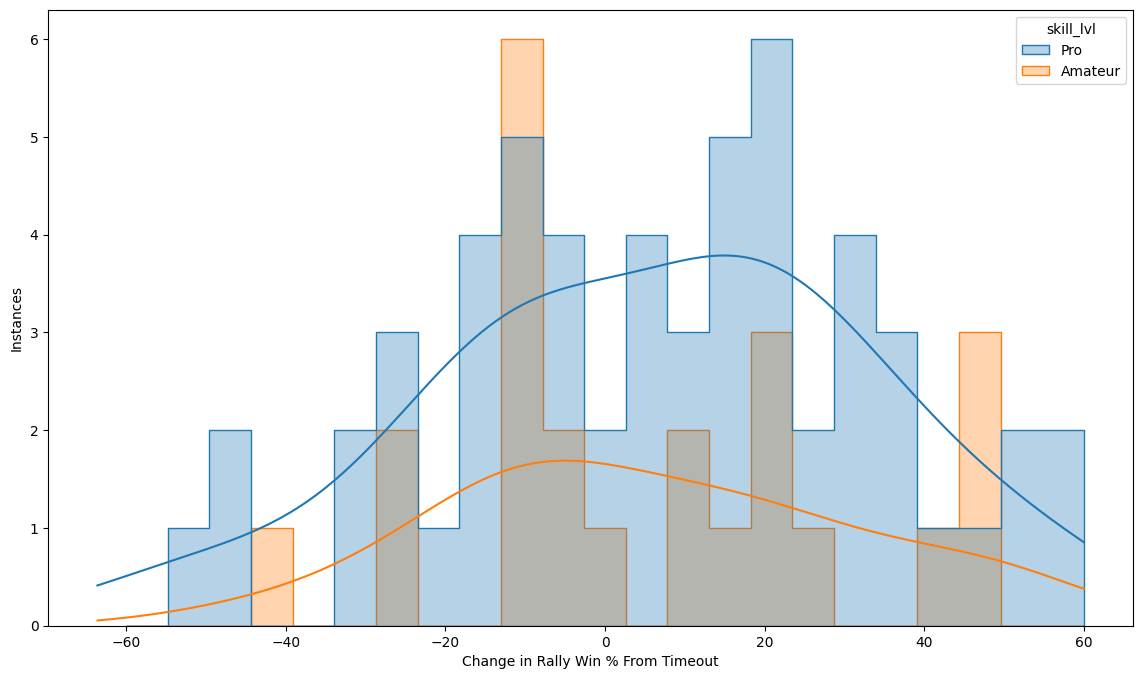

In [34]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-60, 60, 24)
p=sns.histplot(x="deltawin",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Rally Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

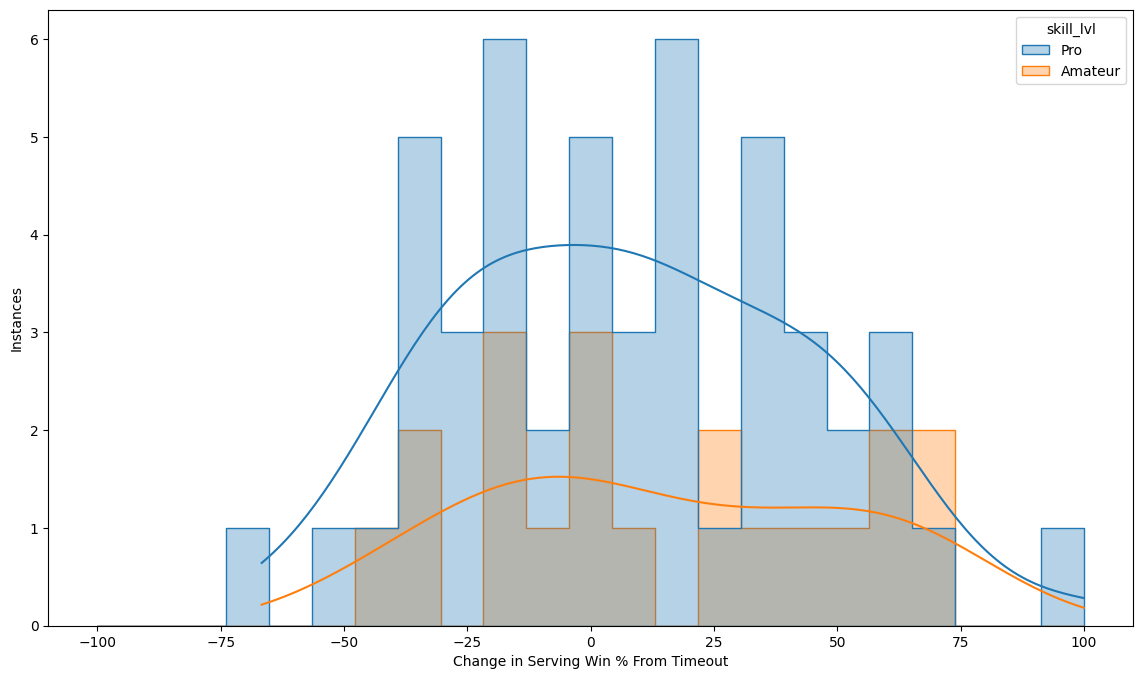

In [35]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 24)
p=sns.histplot(x="deltawinsrv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Serving Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

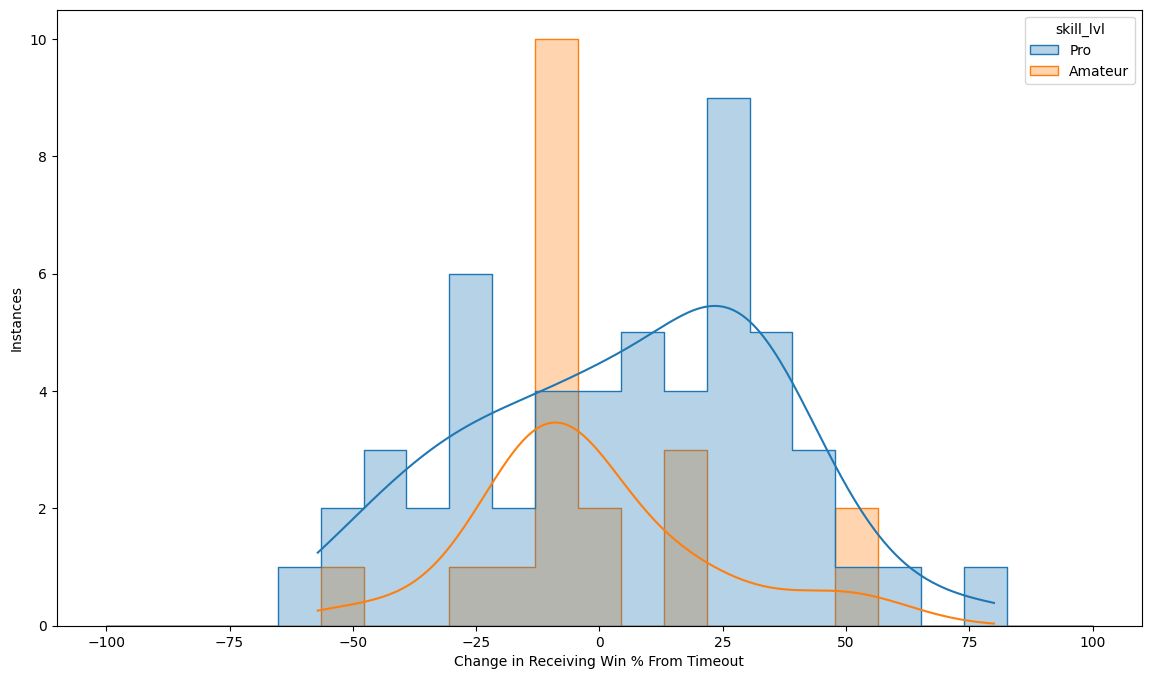

In [36]:
fig, ax = plt.subplots(figsize=(14, 8))
HIST_BINS = np.linspace(-100, 100, 24)
p=sns.histplot(x="deltawinrcv",data=df_timeout,hue="skill_lvl",bins=HIST_BINS,stat="count",alpha=.33,kde=True,\
             common_norm=True,discrete=False,common_bins=True,fill=True,element='step',multiple='layer')
p.set_xlabel("Change in Receiving Win % From Timeout",fontsize=10)
p.set_ylabel("Instances",fontsize=10)
plt.show()

mean = solid line, median = dashed line


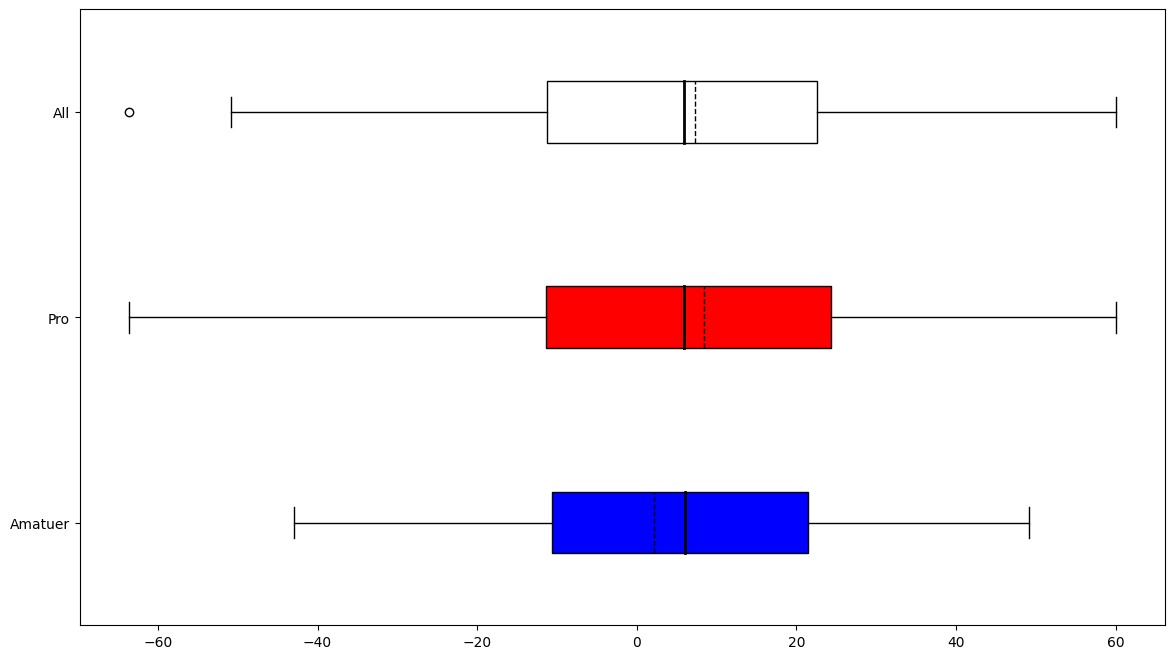

In [37]:
fig, ax = plt.subplots(figsize=(14, 8))
meanlineprops = dict(linestyle='-', linewidth=2.0, color='black')
medianlineprops = dict(linestyle='--', linewidth=1.0, color='black')


box = plt.boxplot(skilldata,autorange=True,vert=0,patch_artist=True,showmeans=True,medianprops=medianlineprops,\
                  meanline=True,meanprops=meanlineprops,labels=['Amatuer','Pro','All'])

colors = ['blue', 'red', 'white']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
print('mean = solid line, median = dashed line')
plt.show()

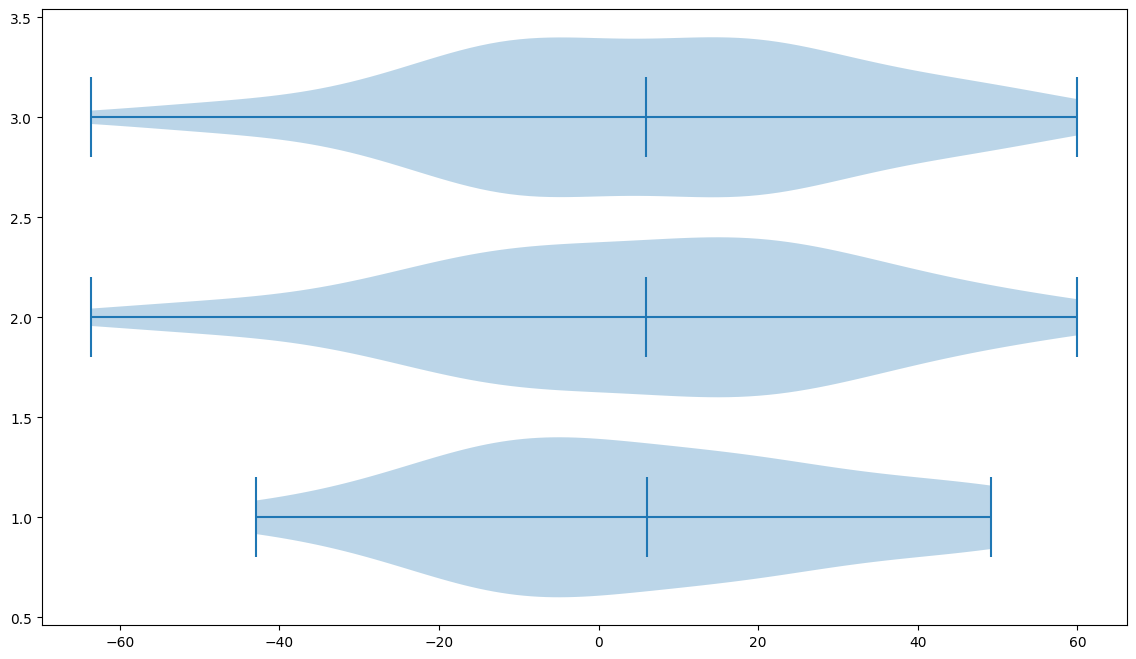

In [38]:
fig, ax = plt.subplots(figsize=(14, 8))
vio=plt.violinplot(skilldata,vert=0,showextrema=True,showmeans=True,widths=.8)
plt.show()